<a href="https://colab.research.google.com/github/PadariyaDebo/C-GAN/blob/main/Copy_of_Conditional_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GAN

In [ ]:
# supress warnings
# Install TensorFlow
!pip install -q tensorflow-gpu==2.0.0-rc0

try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass
import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam
from matplotlib.pyplot import imread

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys, os
from tensorflow.keras.optimizers import Adam

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc0 (from versions: 1.13.1, 1.13.2, 1.14.0, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.1.4, 2.2.0, 2.2.1, 2.2.2, 2.2.3, 2.3.0, 2.3.1, 2.3.2, 2.3.3, 2.3.4, 2.4.0, 2.4.1, 2.4.2, 2.4.3, 2.4.4, 2.5.0, 2.5.1, 2.5.2, 2.5.3, 2.6.0, 2.6.1, 2.6.2, 2.6.3, 2.6.4, 2.6.5, 2.7.0rc0, 2.7.0rc1, 2.7.0, 2.7.1, 2.7.2, 2.7.3, 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc0
`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.
2.8.2


In [ ]:
# import dataset 
from keras.datasets import mnist

(X_train,y_train),(X_test,y_test) = mnist.load_data()
X_train.shape

11501568/11490434 [==============================] - 0s 0us/step


(60000, 28, 28)

In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5876720799402829167
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14465892352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5162763183288808354
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [ ]:
img_width, img_height =28,28
img_channel = 1
img_shape = (img_width, img_height, img_channel)
num_classes = 10
z_dim = 100

# Build Generator

In [ ]:
from keras.layers import UpSampling2D, Reshape, Activation, Conv2D, BatchNormalization, LeakyReLU, Input, Flatten, multiply
from keras.layers import Dense, Embedding
from keras.models import Sequential, Model

def build_generator():
    model = Sequential()
    model.add(Dense(128*7*7, activation = 'relu', input_shape = (z_dim, )))
    model.add(Reshape((7,7,128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size = 3, strides = 1, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(UpSampling2D())
    model.add(Conv2D(1, kernel_size = 3 , strides = 1, padding='same'))
    model.add(Activation('tanh'))
    
    z = Input(shape= (z_dim,))
    label = Input(shape=(1,), dtype = 'int32')
    
    label_embedding = Embedding(num_classes, z_dim, input_length = 1)(label)
    label_embedding = Flatten()(label_embedding)
    joined = multiply([z, label_embedding])
    
    img = model(joined)
    return Model([z, label], img)

generator = build_generator()
generator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 1, 100)       1000        ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 flatten (Flatten)              (None, 100)          0           ['embedding[0][0]']              
                                                                                              

# Build Discriminator

In [ ]:
from keras.layers import Dropout, Concatenate
import numpy as np

def build_discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size = 3, strides = 2, input_shape = (28,28,2), padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Conv2D(64, kernel_size = 3, strides = 2, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Conv2D(128, kernel_size = 3, strides = 2, padding = 'same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha = 0.02))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation = 'sigmoid'))
    
    img = Input(shape= (img_shape))
    label = Input(shape= (1,), dtype = 'int32')
    
    label_embedding = Embedding(input_dim = num_classes, output_dim = np.prod(img_shape), input_length = 1)(label)
    label_embedding = Flatten()(label_embedding)
    label_embedding = Reshape(img_shape)(label_embedding)
    
    concat = Concatenate(axis = -1)([img, label_embedding])
    prediction = model(concat)
    return Model([img, label], prediction)

discriminator = build_discriminator()
discriminator.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 1, 784)       7840        ['input_4[0][0]']                
                                                                                                  
 flatten_2 (Flatten)            (None, 784)          0           ['embedding_1[0][0]']            
                                                                                                  
 input_3 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                            

# Compile and Join Model G/D

In [ ]:

from tensorflow.keras.optimizers import Adam

discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(0.0002, 0.5), metrics = ['accuracy'])

z = Input(shape=(z_dim,))
label = Input(shape= (1,))
img = generator([z,label])

discriminator.trainable = False
prediction = discriminator([img, label])

cgan = Model([z, label], prediction)
cgan.compile(loss= 'binary_crossentropy', optimizer = Adam(0.0002, 0.5))

# Build  a function for training G/D

In [ ]:
def train(epochs, batch_size, save_interval):
    (X_train, y_train), (_, _) = mnist.load_data()
    
    X_train = (X_train - 127.5) / 127.5
    X_train = np.expand_dims(X_train, axis=3)
    
    real = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))
    
    for iteration in range(epochs):
        
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs, labels = X_train[idx], y_train[idx]
        
        z = np.random.normal(0, 1, size=(batch_size, z_dim))
        gen_imgs = generator.predict([z, labels])
        
        d_loss_real = discriminator.train_on_batch([imgs, labels], real)
        d_loss_fake = discriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        
        z = np.random.normal(0, 1, size=(batch_size, z_dim))
        labels = np.random.randint(0, num_classes, batch_size).reshape(-1, 1)
        
        g_loss = cgan.train_on_batch([z, labels], real)
        
        if iteration % save_interval == 0:
            print('{} [D loss: {}, accuracy: {:.2f}] [G loss: {}]'.format(iteration, d_loss[0], 100 * d_loss[1], g_loss))
            save_image(iteration)


In [ ]:
import matplotlib.pyplot as plt
def save_image(epoch):
    r, c = 2,5
    z = np.random.normal(0,1,(r*c, z_dim))
    labels = np.arange(0,10).reshape(-1,1)
    gen_image = generator.predict([z,labels])
    gen_image = 0.5 * gen_image + 0.5
    
    fig, axes = plt.subplots(r,c, figsize = (10,10))
    count = 0
    for i in range(r):
        for j in range(c):
            axes[i,j].imshow(gen_image[count,:,:,0],cmap = 'gray')
            axes[i,j].axis('off')
            axes[i,j].set_title("Digit: %d" % labels[count])
            count+=1
    plt.savefig('images/cgan_%d.jpg' % epoch)
    plt.close()

0 [D loss: 0.19236138463020325, accuracy: 97.27] [G loss: 0.6016339659690857]


FileNotFoundError: ignored

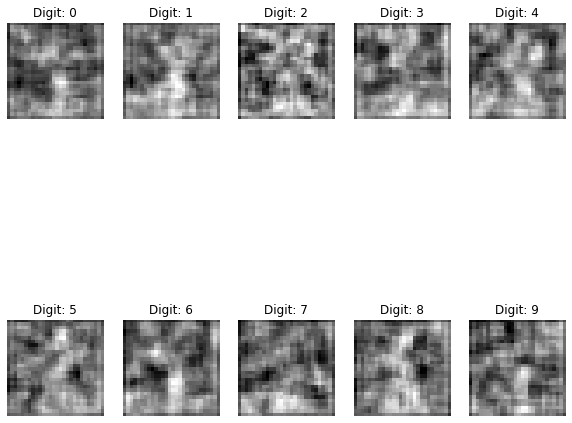

In [ ]:
# train network
train(50000, 128, 1000)